# Benchmarking results exact matches library search
The results of running MS2Query, MS2Deepscore and  cosine on the test spectra of all spectra from 3000 spectra, that do have at least 1 exact library hit is visualized below. In the file generate_predictions_for_test_data the predictions are generated and stored in the format: List[Tuple(best_spectrum_id, predicted_score)] None is given for spectra that fall outside of the set mass tolerance.

In [63]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ms2query.utils import load_pickled_file

# General file locations
data_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data"
benchmarking_results_folder = os.path.join(data_folder, "libraries_and_models/gnps_15_12_2021/benchmarking")
library_folder = os.path.join(data_folder, "libraries_and_models/gnps_15_12_2021/")
sqlite_file_location = os.path.join(library_folder, "library_gnps_15_12/library_GNPS_15_12_2021.sqlite")

test_spectra_3000 = load_pickled_file(os.path.join(library_folder,
                                                   "in_between_files/GNPS_15_12_2021_pos_test_3000_spectra.pickle"))

# Load in predictions:
df_results_ms2query = pd.read_csv(os.path.join(benchmarking_results_folder, "GNPS_15_12_2021_pos_test_3000_spectra.csv"))
results_cosine_min_match_0 = load_pickled_file(os.path.join(benchmarking_results_folder, "highest_cosine_mass_tol_025_fragment_005_min_matched_0_test_spectra_3000.pickle"))
results_cosine = load_pickled_file(os.path.join(benchmarking_results_folder, "highest_cosine_mass_tol_025_fragment_005_min_matched_3_test_spectra_3000.pickle"))
results_ms2deepscore = load_pickled_file(os.path.join(benchmarking_results_folder, "ms2deepscores_within_0_25_Da_test_spectra_3000.pickle"))


In [64]:
# convert to list with tuple format and add spectrum objects
results_ms2query_3000 = [(x[0], x[1], test_spectra_3000[x[2]-1]) for x in df_results_ms2query[["spectrum_ids", "ms2query_model_prediction", "query_spectrum_nr"]].to_numpy()]
results_cosine_3000 = [(results_cosine[i][0], results_cosine[i][1], test_spectra_3000[i]) for i in range(len(test_spectra_3000))]
results_cosine_3000_min_match_0 = [(results_cosine_min_match_0[i][0], results_cosine_min_match_0[i][1], test_spectra_3000[i]) for i in range(len(test_spectra_3000))]
results_ms2deepscore_3000 = [(results_ms2deepscore[i][0], results_ms2deepscore[i][1], test_spectra_3000[i]) for i in range(len(test_spectra_3000))]

In [65]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
from tqdm.notebook import tqdm

def assert_correct_match(results, sqlite_file_location):
    correct_match_list = []
    for best_match_spectrum_id, predicted_score, test_spectrum in tqdm(results):
        if best_match_spectrum_id is not None:
            test_spectrum_inchikey = test_spectrum.get("inchikey")[:14]
            best_match_inchikey = get_metadata_from_sqlite(sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
            true_match = best_match_inchikey == test_spectrum_inchikey
            correct_match_list.append((true_match, predicted_score))
    return correct_match_list


In [66]:
results_ms2query = assert_correct_match(results_ms2query_3000, sqlite_file_location)
results_cosine = assert_correct_match(results_cosine_3000, sqlite_file_location)
results_cosine_min_match_0 = assert_correct_match(results_cosine_3000_min_match_0, sqlite_file_location)
results_ms2deepscore = assert_correct_match(results_ms2deepscore_3000, sqlite_file_location)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [48]:
def count_true_per_threshold(results, threshold):
    count = 0
    total = 0
    for correct, score in results:
        if score >= threshold:
            total += 1
            if correct:
                count +=1
    recall = total/3000
    print(count)
    print(round(count/total, 3))
    print(round(recall, 3))

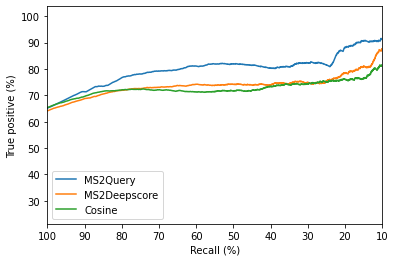

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def accuracy_vs_recall(results, legend_label, nr_of_spectra):
    """Plots the average tanimoto vs recall"""
    percentages_found = []
    percentage_true = []
    sorted_scores = sorted(results, key=lambda tup: tup[1])
    for i in range(len(sorted_scores)):
        selected_scores = [scores[0] for scores in sorted_scores[i:]]
        # Count true positives
        true_positive = sum(selected_scores)
        false_postive = len(selected_scores) - true_positive
        
        percentages_found.append(len(selected_scores)/nr_of_spectra*100)
        percentage_true.append(true_positive/len(selected_scores)*100)
    plt.plot(percentages_found, percentage_true, label = legend_label)
    plt.xlim(100,10)
#     plt.ylim(0.4, 1)
    plt.xlabel("Recall (%)")
    plt.ylabel("True positive (%)")
    plt.legend(loc = "lower left", 
#                title = "Select on highest:"
              )
accuracy_vs_recall(results_ms2query, "MS2Query", 3000)
# accuracy_vs_recall(results_cosine, "Cosine", 3000)
accuracy_vs_recall(results_ms2deepscore, "MS2Deepscore", 3000)
accuracy_vs_recall(results_cosine_min_match_0, "Cosine", 3000)

In [60]:
count_true_per_threshold(results_ms2query, 0)
count_true_per_threshold(results_cosine, 0)
count_true_per_threshold(results_ms2deepscore, 0)

1954
0.651
1.0
158
0.055
0.956
1922
0.642
0.999
